In [1]:
import sqlite3

con = sqlite3.connect("../scripts/8.db", isolation_level=None)
con.execute("PRAGMA journal_mode=WAL;")
cursor = con.cursor()

In [2]:
cursor.execute("SELECT COUNT(*) FROM mace_output;")
row_count = cursor.fetchone()[0]
print(row_count)

1000000


In [3]:
import re
from tqdm.notebook import tqdm
import pandas as pd

In [4]:
cursor.execute("SELECT output FROM mace_output")
err = 0
total = 0
for row in tqdm(range(row_count)):
    total += 1
    output = cursor.fetchone()[0]
    cardinality = int(re.search(r".*= DOMAIN SIZE (.*) =.*", output).groups()[0])
    search_result = re.search(r".*INPUT(.*)end of input.*", output, re.DOTALL)
    input_lines = search_result.groups()[0]
    x = set()
    for equation in re.finditer(r"(\d+) \* (\d+) = (\d+)\.", input_lines):
        i, j, k = map(int, equation.groups())
        ind = cardinality * i + j
        if ind in x:
            err += 1
            break
        else:
            x.add(ind)

  0%|          | 0/1000000 [00:00<?, ?it/s]

In [5]:
print(err, total)

0 1000000


In [6]:
cursor.execute("ALTER TABLE mace_output ADD COLUMN exit_code STRING")

In [7]:
cursor.execute("SELECT rowid, output FROM mace_output")
insert_cursor = con.cursor()
for row in tqdm(range(row_count)):
    data = cursor.fetchone()
    output = data[1]
    row_id = data[0]
    exit_code = re.search(r"Process \d* exit \((.*)\).*", output).groups()[0]
    insert_cursor.execute(
        "UPDATE mace_output SET exit_code = ? WHERE rowid = ?",
        (exit_code, row_id)
    )
insert_cursor.close()

  0%|          | 0/1000000 [00:00<?, ?it/s]

In [8]:
cursor.execute("ALTER TABLE mace_output ADD COLUMN number_of_cells INTEGER")
cursor.execute("ALTER TABLE mace_output ADD COLUMN cardinality INTEGER")

In [9]:
cursor.execute("SELECT rowid, output FROM mace_output")
insert_cursor = con.cursor()
for row in tqdm(range(row_count)):
    data = cursor.fetchone()
    output = data[1]
    row_id = data[0]
    cardinality = int(re.search(r".*= DOMAIN SIZE (.*) =.*", output).groups()[0])
    insert_cursor.execute(
        "UPDATE mace_output SET cardinality = ? WHERE rowid = ?",
        (cardinality, row_id)
    )
    search_result = re.search(r".*INPUT(.*)end of input.*", output, re.DOTALL)
    input_lines = search_result.groups()[0]
    eq_num = 0
    for equation in re.finditer(r"(\d+) \* (\d+) = (\d+)\.", input_lines):
        eq_num += 1
    insert_cursor.execute(
        "UPDATE mace_output SET number_of_cells = ? WHERE rowid = ?",
        (eq_num, row_id)
    )

  0%|          | 0/1000000 [00:00<?, ?it/s]

In [10]:
cursor.execute("""
SELECT
    cardinality,
    number_of_cells,
    AVG(model_exists) percentage,
    SUM(model_exists) models,
    COUNT(*) tasks
FROM mace_output
GROUP BY
    cardinality,
    number_of_cells
""")
report = pd.DataFrame(
    cursor.fetchall(),
    columns=[
        "cardinality",
        "number_of_cells",
        "percentage",
        "models",
        "tasks"
    ]
)

OperationalError: no such column: model_exists

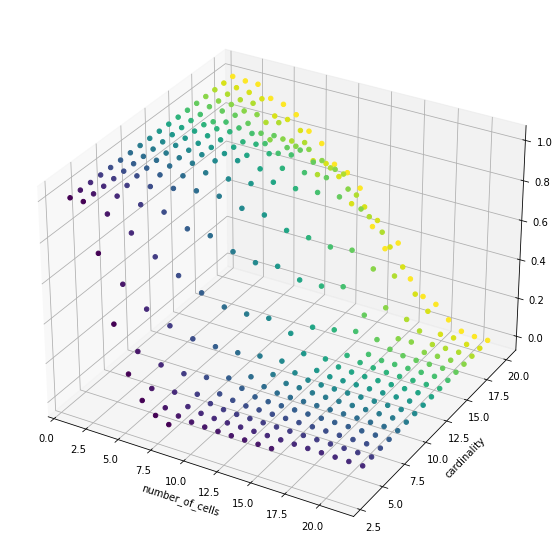

In [39]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(
    figsize=(10, 10)
)
ax = fig.add_subplot(
    111,
    projection="3d",
    xlabel="number_of_cells",
    ylabel="cardinality",
)
ax.scatter(
    report[report["number_of_cells"] <= 21]["number_of_cells"],
    report[report["number_of_cells"] <= 21]["cardinality"],
    report[report["number_of_cells"] <= 21]["percentage"],
    c=report[report["number_of_cells"] <= 21]["cardinality"],
    depthshade=False
)

<AxesSubplot:xlabel='number_of_cells'>

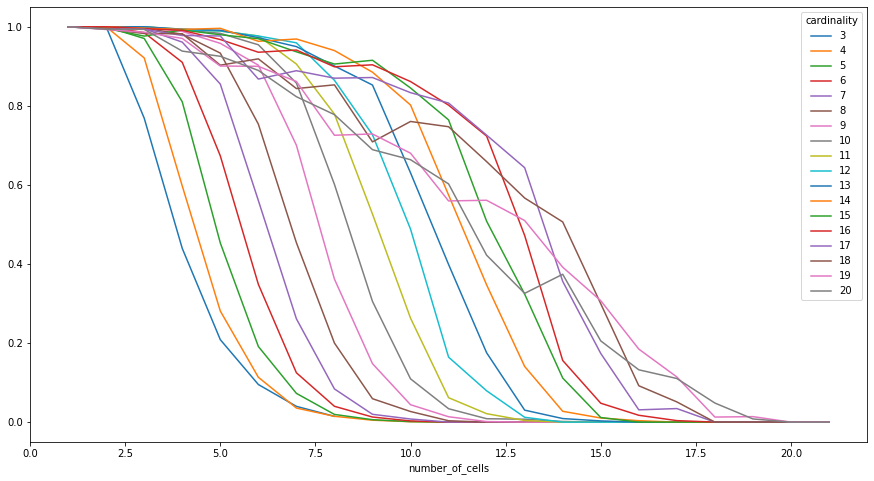

In [44]:
(
    report
    [report["number_of_cells"] <= 21]
    .pivot(
        index="number_of_cells",
        columns="cardinality",
        values="percentage"
    )
    .plot(
        figsize=(15, 8)
    )
)

<AxesSubplot:xlabel='number_of_cells'>

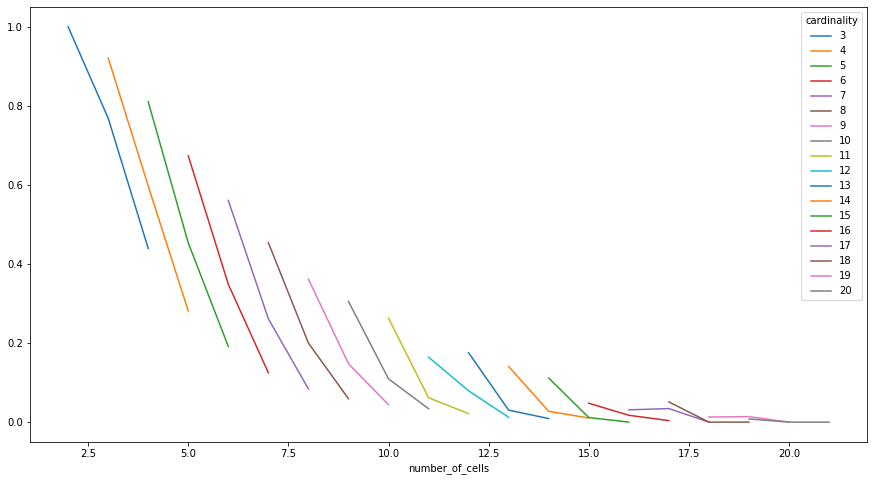

In [58]:
(
    report.query(
        "abs(cardinality - number_of_cells) <= 1"
    ).pivot(
        index="number_of_cells",
        columns="cardinality",
        values="percentage"
    )
    .plot(
        figsize=(15, 8)
    )
)

In [13]:
cursor.execute("""
SELECT
    cardinality,
    COUNT(*),
    SUM(CASE WHEN exit_code = 'max_models' THEN 1 ELSE 0 END),
    SUM(CASE WHEN exit_code = 'exhausted' THEN 1 ELSE 0 END),
    SUM(CASE WHEN exit_code = 'max_sec_no' THEN 1 ELSE 0 END)
FROM mace_output
WHERE cardinality <= number_of_cells
GROUP BY cardinality
""")
pd.DataFrame(
    cursor.fetchall(),
    columns=[
        "cardinality",
        "total_count",
        "sat_count",
        "unsat_count",
        "timeout_count"
    ]
)

,cardinality,total_count,sat_count,unsat_count,timeout_count
0,8,888641,4652,883989,0


In [14]:
cursor.execute("""
SELECT
    cardinality,
    COUNT(*),
    SUM(CASE WHEN exit_code = 'max_models' THEN 1 ELSE 0 END),
    SUM(CASE WHEN exit_code = 'exhausted' THEN 1 ELSE 0 END),
    SUM(CASE WHEN exit_code = 'max_sec_no' THEN 1 ELSE 0 END)
FROM mace_output
WHERE cardinality > number_of_cells
GROUP BY cardinality
""")
pd.DataFrame(
    cursor.fetchall(),
    columns=[
        "cardinality",
        "total_count",
        "sat_count",
        "unsat_count",
        "timeout_count"
    ]
)

,cardinality,total_count,sat_count,unsat_count,timeout_count
0,8,111359,98059,13300,0
